In [1]:
import traci
import os, sys
import sumolib
import pandas as pd
import math
import numpy as np
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt

In [2]:
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:   
    sys.exit("please declare environment variable 'SUMO_HOME'")

In [3]:
# parse the net
net = sumolib.net.readNet('Nashville_final.net.xml')

In [11]:
traci.start(["sumo", "-n", "Nashville_final.net.xml"])

#Get geographic coordinates of bus stops

Stops = pd.read_excel('union_all_trips.xlsx',sheet_name = "union_all_trips").copy()
Pickup_LAT = Stops['pickup_lat']
Pickup_LON = Stops['pickup_lon']

#Convert geographic coordinates to position info (edge ID, lane position and lane index)
def get_edge(lon, lat):
    edgeID, lanePosition, laneIndex = traci.simulation.convertRoad(lon,lat, True)
    return edgeID, lanePosition, laneIndex

edgeinf =[]
for i in range(len(Pickup_LAT)):
    edgeinf.append(get_edge(Pickup_LON[i],Pickup_LAT[i]))
# Write to     
df = pd.DataFrame(edgeinf, columns=['O_edgeID', 'O_lanepos', 'O_laneind'])
df.to_excel(r'origin.xlsx', index = False)
traci.close()

In [12]:
traci.start(["sumo", "-n", "Nashville_final.net.xml"])

#Get geographic coordinates of bus stops

Stops = pd.read_excel('union_all_trips.xlsx',sheet_name = "union_all_trips").copy()
Dropoff_LAT = Stops['dropoff_lat']
Dropoff_LON = Stops['dropoff_lon']

#Convert geographic coordinates to position info (edge ID, lane position and lane index)
def get_edge(lon, lat):
    edgeID, lanePosition, laneIndex = traci.simulation.convertRoad(lon,lat, True)
    return edgeID, lanePosition, laneIndex

edgeinf =[]
for i in range(len(Pickup_LAT)):
    edgeinf.append(get_edge(Dropoff_LON[i],Dropoff_LAT[i]))
# Write to     
df = pd.DataFrame(edgeinf, columns=['D_edgeID', 'D_lanepos', 'D_laneind'])
df.to_excel(r'destination.xlsx', index = False)
traci.close()

In [8]:
# Read the Excel file into a pandas DataFrame
df = pd.read_excel('union_all_trips.xlsx')

# Create the root element of the XML tree
root = ET.Element("routes", attrib={"xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
                                   "xsi:noNamespaceSchemaLocation": "http://sumo.dlr.de/xsd/routes_file.xsd"})

# Iterate over the rows in the DataFrame
for index, row in df.iterrows():
    # Create a trip element for each row
    trip = ET.SubElement(root, "trip", attrib={"id": "t{}".format(index+1),
                                               "depart": str(row['pickup_time_secs']),
                                               "from": str(row['O_edgeID']),
                                               "to": str(row['D_edgeID']),
                                               "type": "passenger",
                                               "departLane": "best",
                                               "departPos": "free",
                                               "departSpeed": "avg"})
    
    # Add indentation before the trip element
    trip.text = "\n" + " " * 4

# Create the XML tree
tree = ET.ElementTree(root)

# Set the indent level to 3 spaces
ET.indent(tree, space=" ", level=3)

# Write the XML tree to a file
tree.write("chatt2_output.xml", encoding="utf-8", xml_declaration=True)




KeyboardInterrupt: 

duarouter --route-files Nashville_output.xml -n  Nashville_final.net.xml --unsorted-input  --ptline-routing --output-file trip.rou.xml --ignore-errors

DUA

python3 (Home to) \duaIterate.py --net-file Chattanooga_SUMO_Network.net.xml -t output.xml -l 2 -C -m   -E -L --time-to-teleport 50 --clean-alt    default steps is 50  we used 10 

# Run the simulation and compare with RSD

C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:199: UserWarning: API change now handles step as floating point seconds
  return connection.check().simulationStep(step)


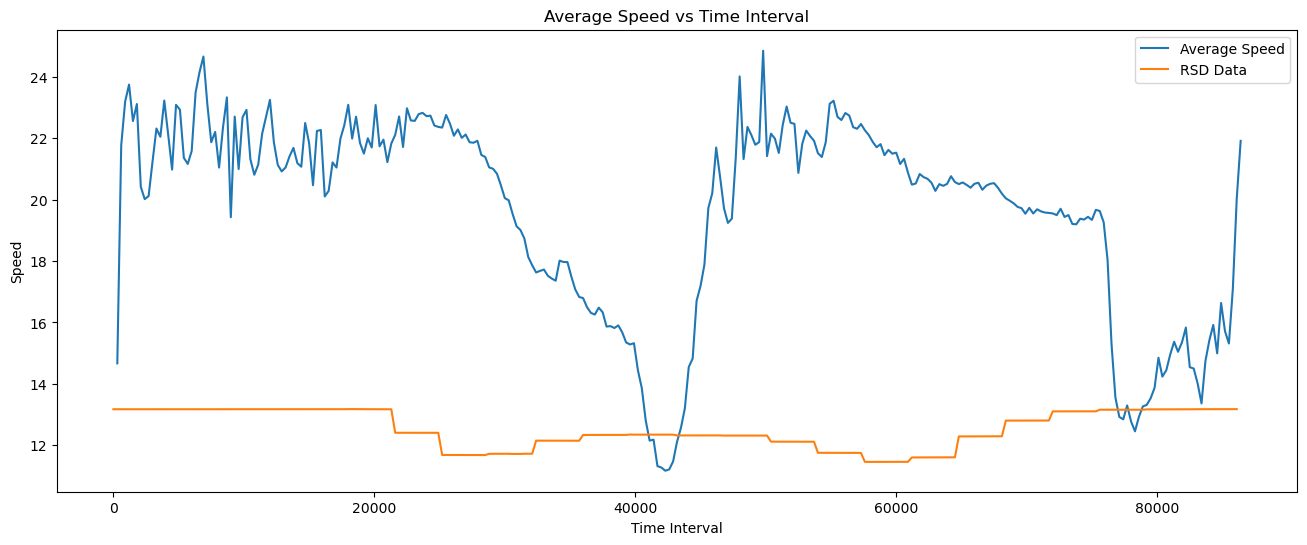

In [43]:
# Load the RSD data from the Excel file
rsd_data = pd.read_excel('RSD.xlsx')
rsd_time = rsd_data['time'].tolist()
rsd_speed = rsd_data['rsd'].tolist()

# Start the TraCI simulation and load the network
traci.start(["sumo", "-n", "Nashville_final.net.xml", 
             "--route-files", "trip_016.rou.xml",
             "--time-to-teleport", "300", "--time-to-teleport.disconnected", "300",
             "--mesosim", "true", "--time-to-teleport.highways", "300",
             "--meso-junction-control.limited", "true", "--meso-overtaking", "true",
             "--meso-tls-penalty", "0.9"])

# Run the simulation for the specified time
end_time = 86400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)



# Plot the average speed and RSD data
plt.figure(figsize=(16, 6))  
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()


In [25]:
traci.close()

C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:199: UserWarning: API change now handles step as floating point seconds
  return connection.check().simulationStep(step)


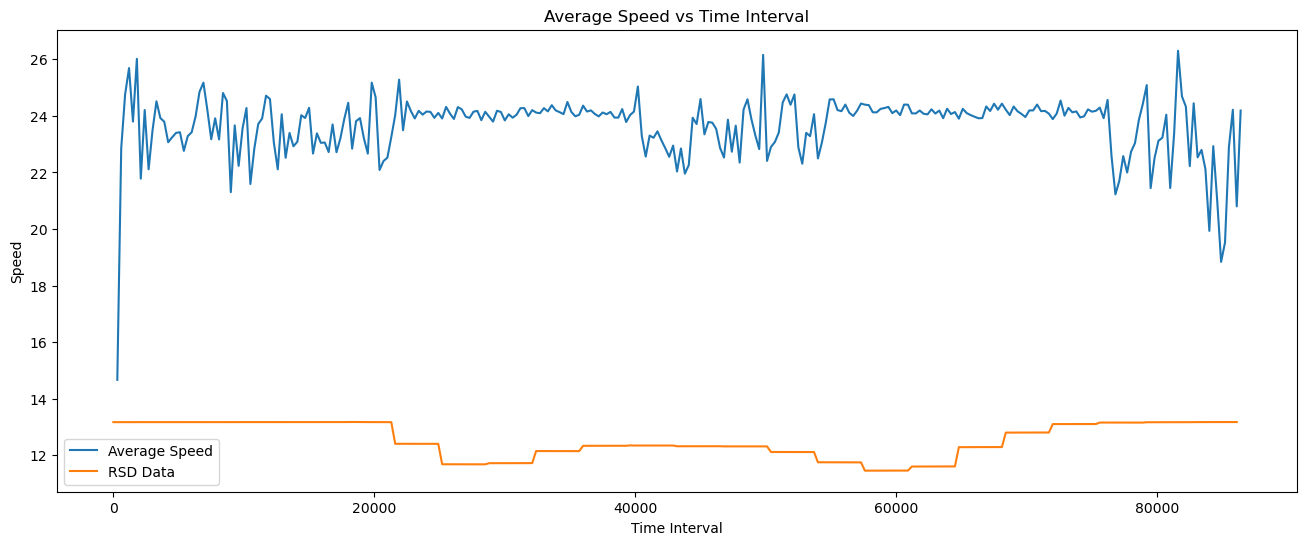

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import traci

# Load the RSD data from the Excel file
rsd_data = pd.read_excel('RSD.xlsx')
rsd_time = rsd_data['time'].tolist()
rsd_speed = rsd_data['rsd'].tolist()

# Define the scale factor for increasing the number of vehicles
scale_factor = 4  # Increase the number of vehicles by a factor of 2

# Generate a new route file with an increased number of vehicles
route_file = "trip_016.rou.xml"
new_route_file = "trip_016_scaled.rou.xml"
with open(route_file, 'r') as f_in, open(new_route_file, 'w') as f_out:
    for line in f_in:
        if '<vehicle ' in line:
            line = line.replace('/>', ' departLane="best" departSpeed="0"/>\n' * scale_factor)
        f_out.write(line)

# Start the TraCI simulation and load the network
traci.start(["sumo", "-n", "Nashville_final.net.xml",
             "--route-files", new_route_file,
             "--time-to-teleport", "300", "--time-to-teleport.disconnected", "300",
             "--mesosim", "true", "--time-to-teleport.highways", "300",
             "--meso-junction-control.limited", "true", "--meso-overtaking", "true",
             "--meso-tls-penalty", "0.5"])

# Run the simulation for the specified time
end_time = 86400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)

# Plot the average speed and RSD data
plt.figure(figsize=(16, 6))
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()


C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:199: UserWarning: API change now handles step as floating point seconds
  return connection.check().simulationStep(step)


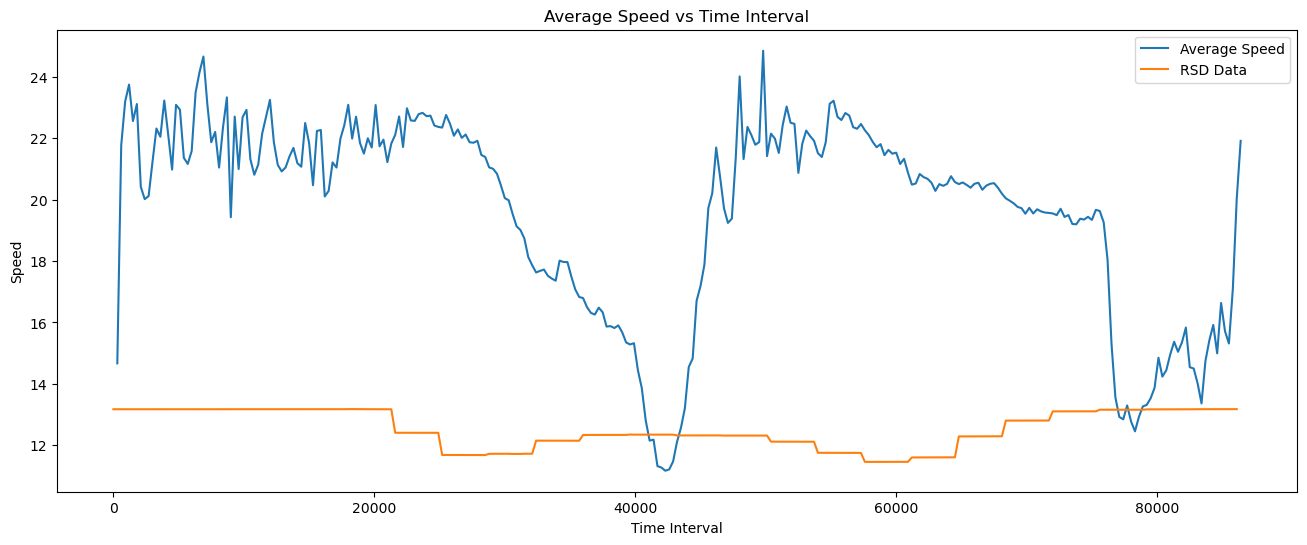

In [31]:
# Load the RSD data from the Excel file
rsd_data = pd.read_excel('RSD.xlsx')
rsd_time = rsd_data['time'].tolist()
rsd_speed = rsd_data['rsd'].tolist()

# Define the scale factor for increasing the number of vehicles
vehicle_scale_factor = 3  # Increase the number of vehicles by a factor of 2
speed_scale_factor = 0.4  # Scale the speeds of vehicles by a factor of 1.5

# Generate a new route file with an increased number of vehicles
route_file = "trip_016.rou.xml"
new_route_file = "trip_016_scaled.rou.xml"
with open(route_file, 'r') as f_in, open(new_route_file, 'w') as f_out:
    for line in f_in:
        if '<vehicle ' in line:
            line = line.replace('/>', f' departLane="best" departSpeed="0" speedFactor="{speed_scale_factor}"/>\n' * vehicle_scale_factor)
        f_out.write(line)

# Start the TraCI simulation and load the network
traci.start(["sumo", "-n", "Nashville_final.net.xml",
             "--route-files", new_route_file,
             "--time-to-teleport", "300", "--time-to-teleport.disconnected", "300",
             "--mesosim", "true", "--time-to-teleport.highways", "300",
             "--meso-junction-control.limited", "true", "--meso-overtaking", "true",
             "--meso-tls-penalty", "0.9"])

# Run the simulation for the specified time
end_time = 86400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)

# Plot the average speed and RSD data
plt.figure(figsize=(16, 6))
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()


C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:199: UserWarning: API change now handles step as floating point seconds
  return connection.check().simulationStep(step)


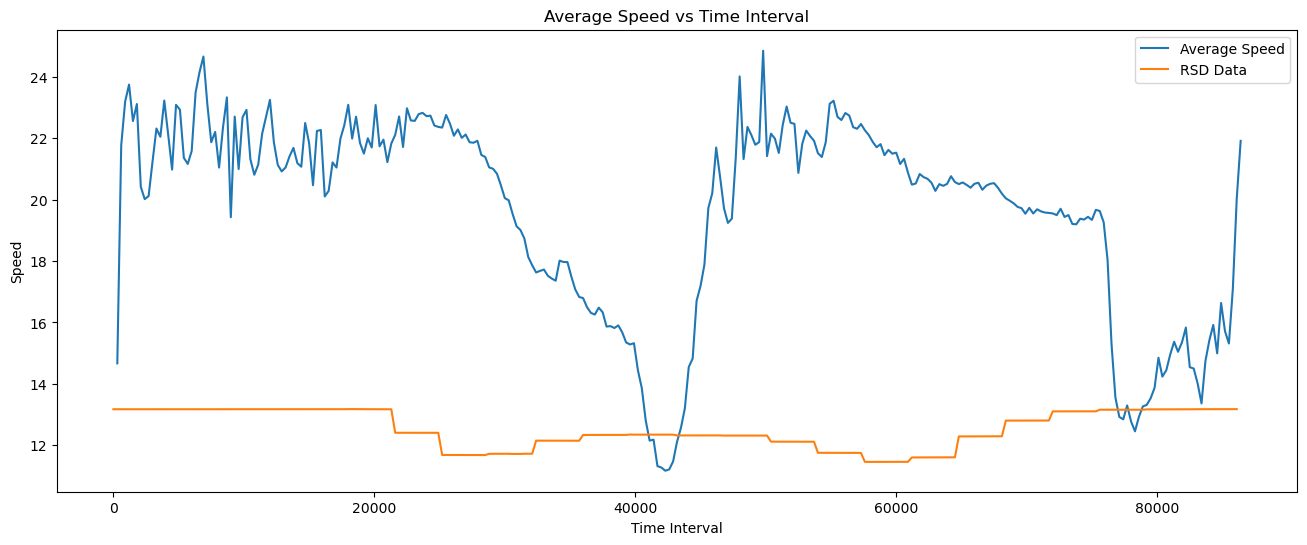

In [32]:
# Load the RSD data from the Excel file
rsd_data = pd.read_excel('RSD.xlsx')
rsd_time = rsd_data['time'].tolist()
rsd_speed = rsd_data['rsd'].tolist()

# Define the scale factor for increasing the number of vehicles
vehicle_scale_factor = 2  # Increase the number of vehicles by a factor of 2
speed_scale_factor = .5  # Scale the speeds of vehicles by a factor of 1.5

# Generate a new route file with an increased number of vehicles
route_file = "trip_016.rou.xml"
new_route_file = "trip_016_scaled.rou.xml"
with open(route_file, 'r') as f_in, open(new_route_file, 'w') as f_out:
    for line in f_in:
        if '<vehicle ' in line:
            line = line.replace('/>', f' departLane="best" departSpeed="0" speedFactor="{speed_scale_factor}" maxSpeed="12"/>\n' * vehicle_scale_factor)
        f_out.write(line)

# Start the TraCI simulation and load the network
traci.start(["sumo", "-n", "Nashville_final.net.xml",
             "--route-files", new_route_file,
             "--time-to-teleport", "300", "--time-to-teleport.disconnected", "300",
             "--mesosim", "true", "--time-to-teleport.highways", "300",
             "--meso-junction-control.limited", "true", "--meso-overtaking", "true",
             "--meso-tls-penalty", "0.9"])

# Run the simulation for the specified time
end_time = 86400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)

# Plot the average speed and RSD data
plt.figure(figsize=(16, 6))
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()


C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:199: UserWarning: API change now handles step as floating point seconds
  return connection.check().simulationStep(step)


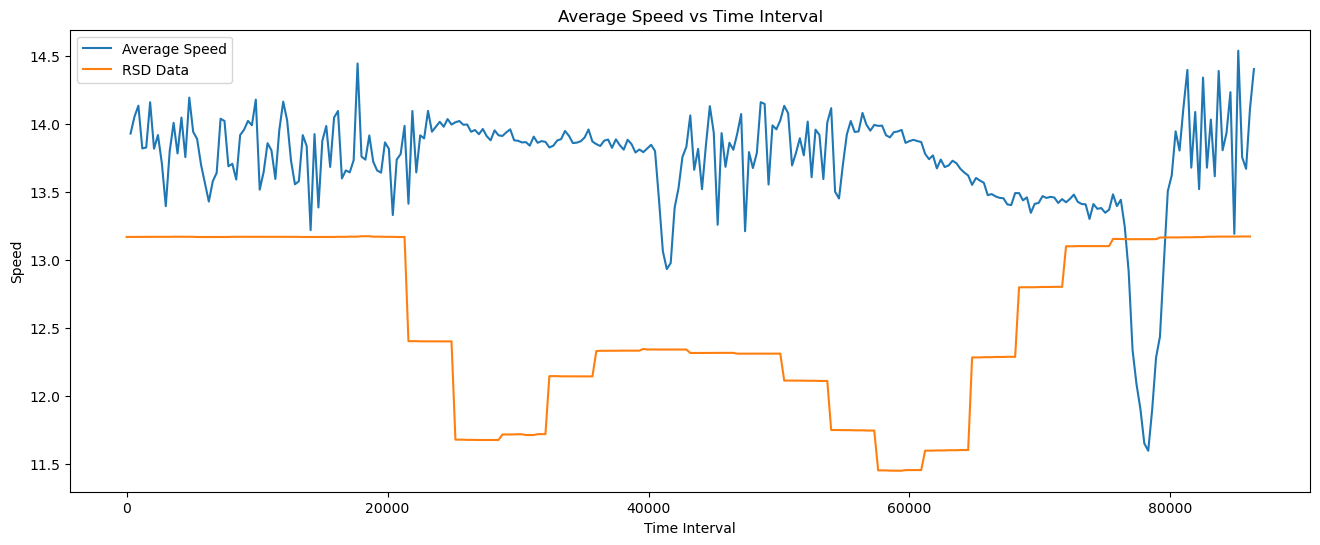

In [59]:
# Load the RSD data from the Excel file
rsd_data = pd.read_excel('RSD.xlsx')
rsd_time = rsd_data['time'].tolist()
rsd_speed = rsd_data['rsd'].tolist()

# Start the TraCI simulation and load the network
traci.start(["sumo", "-n", "Nashville_final.net.xml", 
             "--route-files", "trip_016.rou.xml",
             "--time-to-teleport", "250", "--time-to-teleport.disconnected", "250",
             "--mesosim", "true", "--time-to-teleport.highways", "250",
             "--meso-junction-control.limited", "true", "--meso-overtaking", "true",
             "--meso-tls-penalty", "0.7"])

# Set the maximum speed for all vehicle types to 14 m/s
for vehicle_type in traci.vehicletype.getIDList():
    traci.vehicletype.setMaxSpeed(vehicle_type, 15)

# Run the simulation for the specified time
end_time = 86400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)

# Plot the average speed and RSD data
plt.figure(figsize=(16, 6))  
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()



In [46]:
traci.close()

C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:199: UserWarning: API change now handles step as floating point seconds
  return connection.check().simulationStep(step)


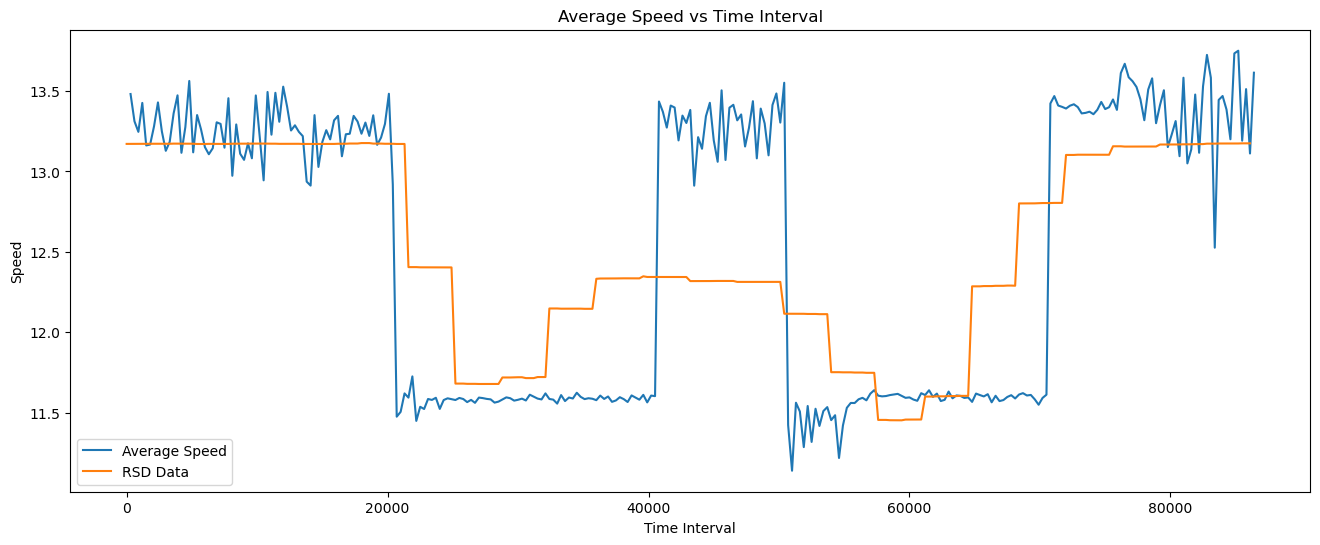

In [55]:
# Load the RSD data from the Excel file
rsd_data = pd.read_excel('RSD.xlsx')
rsd_time = rsd_data['time'].tolist()
rsd_speed = rsd_data['rsd'].tolist()

# Start the TraCI simulation and load the network
traci.start(["sumo", "-n", "Nashville_final.net.xml", 
             "--route-files", "trip_016.rou.xml",
             "--time-to-teleport", "300", "--time-to-teleport.disconnected", "300",
             "--mesosim", "true", "--time-to-teleport.highways", "300",
             "--meso-junction-control.limited", "true", "--meso-overtaking", "true",
             "--meso-tls-penalty", "0.5"])

# Set the maximum speed for all vehicle types to 14 m/s initially
for vehicle_type in traci.vehicletype.getIDList():
    traci.vehicletype.setMaxSpeed(vehicle_type, 14)

# Run the simulation for the specified time
end_time = 86400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Set speed limitations for the time intervals
    if 20000 <= current_time <= 40000 or 50000 <= current_time <= 70000 :
        for vehicle_type in traci.vehicletype.getIDList():
            traci.vehicletype.setMaxSpeed(vehicle_type, 12)
    else:
        # Set speed limitation to 14 m/s for the rest of the time
        for vehicle_type in traci.vehicletype.getIDList():
            traci.vehicletype.setMaxSpeed(vehicle_type, 14)

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)

# Plot the average speed and RSD data
plt.figure(figsize=(16, 6))  
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()
